In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
#from collections import Counter
%pip install ucimlrepo

# %% [markdown]
# DATA INGESTION in pipeline

# %%
#Dataset
from ucimlrepo import fetch_ucirepo
cancer_data = fetch_ucirepo(id=17) # fetch dataset
# data (as pandas dataframes)
X = cancer_data.data.features
y = cancer_data.data.targets
ids= cancer_data.data.ids


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Check the shape of data
print(f"Features shape: {X.shape}") #Features shape:  (569, 30)
print(f"Target shape: {y.shape}") #Target shape: (569, 1)
print(f"IDs shape: {ids.shape}") #IDs shape: (569, 1)

print (y.value_counts()) # Check target distribution: 357 benign (2), 212 malignant (4)
print(X.isnull().sum())# Check for missing values
print("ID CHECK")
print(ids.isnull().sum())# Check for missing values in ids column

# %%

# %%
print(y.describe()) #569

# %% [markdown]
# Data Cleaning - Handle missing values in 'Bare_nuclei' column

# %%
print((X.isnull().sum()/ len(X))) #no empty values
duplicate_check=X.duplicated().any() # Check for duplicate rows
print(f"Are there duplicate rows? {duplicate_check}")

# %% [markdown]
# keep outliers

Features shape: (569, 30)
Target shape: (569, 1)
IDs shape: (569, 1)
Diagnosis
B            357
M            212
Name: count, dtype: int64
radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
dtype: int64
ID CHECK
ID    0
dtype: int64
       Diagnosis
count        569
unique         2
top            B
freq         357
radius1      

Diagnosis
B            62.741652
M            37.258348
Name: proportion, dtype: float64


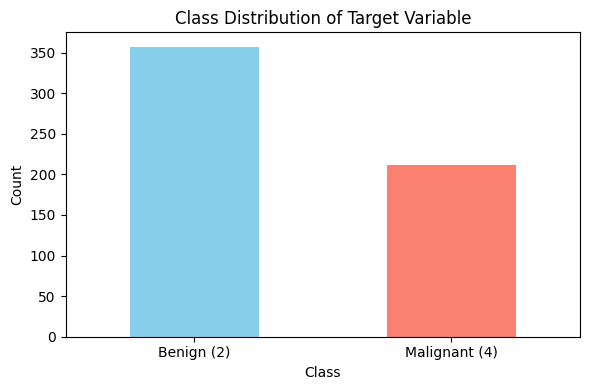

In [4]:
# %%
# Class Distribution
print(y.value_counts(normalize=True)*100) # Class distribution percentages: B- 62.742%, M 37.258%
plt.figure(figsize=(6,4))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution of Target Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Benign (2)', 'Malignant (4)'], rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
# ENCODING
y_encoded= y.replace({2:0, 4:1}) # Encode target variable: 2 -> 0 (benign), 4 -> 1 (malignant)
#y_singleCol= y_encoded.values.ravel()) # Check encoded target values
print("Unique values",y_encoded.nunique()) # Check unique values in encoded target: [0, 1]
print("Value count",y_encoded.value_counts()) # Check encoded target distribution: 0- 357, 1- 212
print("Percentages",y_encoded.value_counts(normalize=True)*100) # Percentages: 0- 62.741652%, 1- 37.258348%


In [14]:
# https://coderivers.org/blog/train-test-split-python/
np.random.seed(42)
test_size=0.2
n_samples=len(X)
n_test=int(test_size * n_samples)

#shuffle indices not the data
shuffle_ind = np.random.permutation(n_samples)

X_train = X.iloc[shuffle_ind[:-n_test]] #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html
X_test = X.iloc[shuffle_ind[-n_test:]]
y_train = y_encoded.iloc[shuffle_ind[:-n_test]]
y_test = y_encoded.iloc[shuffle_ind[-n_test:]]

print(X_train.shape, X_test.shape) # (456, 30) (113, 30)
print(y_train.shape, y_test.shape) # (456,1) (113,1)
print(X_train.head())

(456, 30) (113, 30)
(456, 1) (113, 1)
     radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
204    14.02     15.66       89.59   606.5      0.07966       0.05581   
70     13.49     22.30       86.91   561.0      0.08752       0.07698   
131    18.66     17.12      121.40  1077.0      0.10540       0.11000   
431    13.17     21.81       85.42   531.5      0.09714       0.10470   
540    13.48     20.82       88.40   559.2      0.10160       0.12550   

     concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
204     0.02087          0.02652     0.1589             0.05586  ...    14.91   
70      0.04751          0.03384     0.1809             0.05718  ...    15.15   
131     0.14570          0.08665     0.1966             0.06213  ...    22.25   
431     0.08259          0.05252     0.1746             0.06177  ...    16.23   
540     0.10630          0.05439     0.1720             0.06419  ...    15.53   

     texture3  perimeter3   area3  s

In [ ]:
class LogisticRegression:
    """
    Logistic regression with gradient descent.

    Model: P(y=1|x) = σ(w^T x + b) where σ is the sigmoid function
    Loss: Cross-entropy with L2 regularization

    We use batch gradient descent to optimize. Following Chapter 4 of Hastie et al.
    (Elements of Statistical Learning, 2009) for the theory, with gradient formulas
    from Bishop (2006).

    Parameters:
        learning_rate: Step size α for gradient updates
        num_iterations: How many passes through the data
        regularization: L2 penalty λ to prevent overfitting
    """

    def __init__(self, learning_rate=0.01, num_iterations=1000, regularization=0.01):

        """Initialize logistic regression parameters"""

        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.regularization = regularization
        self.weights = None
        self.bias = None
        self.losses = []  # Track convergence

    def _sigmoid(self, z):
        """
        Sigmoid function: σ(z) = 1 / (1 + e^(-z))
        """
        #Squashes any input to a probability between 0 and 1

        # Clip to prevent overflow in exp()
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Train using gradient descent.

        At each iteration:
            1. Compute predictions: ŷ = σ(Xw + b)
            2. Calculate gradients: ∂L/∂w = (1/n)X^T(ŷ - y) + λw
            3. Update: w ← w - α(∂L/∂w)

        Gradients derived from cross-entropy loss
        """

        n_samples, n_features = X.shape

        # Initialize parameters to zeros
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent optimization
        for iteration in range(self.num_iterations):
            # Forward pass: compute predictions
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            # Compute gradients (using calculus chain rule)
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Add L2 regularization gradient
            dw += (self.regularization / n_samples) * self.weights

            # Update parameters (gradient descent step)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Track loss for convergence monitoring
            if iteration % 100 == 0:
                loss = self._compute_loss(X, y)
                self.losses.append(loss)

    def _compute_loss(self, X, y):
        """
        Compute cross-entropy loss with L2 regularization.

        Loss Function Components:
            1. Cross-Entropy: Measures prediction error
               -1/n Σ[y*log(ŷ) + (1-y)*log(1-ŷ)]

            2. L2 Regularization: Prevents overfitting
               λ/(2n) ||w||²

        Derivation:
            From maximum likelihood estimation (MLE) of Bernoulli distribution
            Negative log-likelihood = cross-entropy

        Args:
            X: Features
            y: True labels

        Returns:
            Total loss value
        """
        n_samples = X.shape[0]
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)

        # Cross-entropy loss (avoid log(0) with epsilon)
        epsilon = 1e-9
        cross_entropy = -np.mean(
            y * np.log(y_predicted + epsilon) +
            (1 - y) * np.log(1 - y_predicted + epsilon)
        )

        # L2 regularization penalty
        l2_penalty = (self.regularization / (2 * n_samples)) * np.sum(self.weights ** 2)

        return cross_entropy + l2_penalty

    def predict_proba(self, X):
        """Return probability of positive class using sigmoid(w·x + b)."""

        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        """Predict class labels: 1 if P(y=1) ≥ threshold, else 0."""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)



In [ ]:
class LogisticRegression: 
    
    def __init__(self, learning_rate=0.01, num_iterations=1000, regularization=0.01):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.regularization = regularization
        self.weights = None
        self.bias = None
        self.losses = []  # Track convergence

    def fit(self, X,y): #gradient descent
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.num_iterations):
            # Linear model
            y_pred=np.dot(X, self.weights) + self.bias
            # Apply sigmoid activation
            y_predicted = 1 / (1 + np.exp(-y_pred))
            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y)) + (self.regularization / n_samples) * self.weights
            db = (1 / n_samples) * np.sum(y_predicted - y)  

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Compute loss for monitoring
            loss = - (1 / n_samples) * np.sum(y * np.log(y_predicted + 1e-15) + (1 - y) * np.log(1 - y_predicted + 1e-15)) + (self.regularization / (2 * n_samples)) * np.sum(self.weights ** 2)
            self.losses.append(loss)

    def predict(self, X):       
        y_pred = np.dot(X, self.weights) + self.bias
        #y_predicted = 1 / (1 + np.exp(-y_pred))
        #y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_pred)
    
    def r2_score(self, X, y):
        y_pred = self.predict(X)
        ss_total = np.sum((y - np.mean(y)) ** 2)
        ss_residual = np.sum((y - y_pred) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        return r2
    
    def mse(self, X, y):
        y_pred = self.predict(X)
        mse = np.mean((y - y_pred) ** 2)
        return mse